# imports

In [121]:
from collections import Counter
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from matplotlib_venn import venn2

plt.style.use("dark_background")
sns.set_palette("muted")

# data import

In [3]:
RESULTS_DIR = Path.cwd().parent / "results"

# TODO this probably does not work on Windows
!cat $RESULTS_DIR/preference/generator*/results.jsonl > $RESULTS_DIR/preference/results_combined.jsonl
!cat $RESULTS_DIR/attribution/generator*/results.jsonl > $RESULTS_DIR/attribution/results_combined.jsonl
!wc -l $RESULTS_DIR/preference/results_combined.jsonl
!wc -l $RESULTS_DIR/attribution/results_combined.jsonl

3336 /home/jason/dev/acs/TuringMirror/results/preference/results_combined.jsonl
5670 /home/jason/dev/acs/TuringMirror/results/attribution/results_combined.jsonl


In [4]:
df_pref = pd.read_json(RESULTS_DIR / "preference/results_combined.jsonl" , lines=True)
df_pref.shape

(3336, 12)

In [5]:
df_attr = pd.read_json(RESULTS_DIR / "attribution/results_combined.jsonl" , lines=True)
df_attr.shape

(5670, 12)

In [31]:
# combine id and predictor into a unique id
df_attr["uid"] = df_attr["id"].astype(str) + "_" + df_attr["predictor"].astype(str)
df_pref["uid"] = df_pref["id"].astype(str) + "_" + df_pref["predictor"].astype(str)
df_attr.uid.is_unique, df_pref.uid.is_unique

(True, True)

In [42]:
# use UID as index
df_attr = df_attr.set_index("uid")
df_pref = df_pref.set_index("uid")

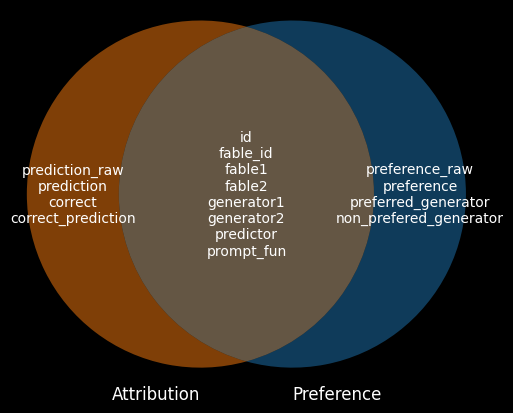

10 ['prediction_raw', 'prediction', 'correct', 'correct_prediction']
01 ['preference_raw', 'preference', 'preferred_generator', 'non_prefered_generator']
11 ['id', 'fable_id', 'fable1', 'fable2', 'generator1', 'generator2', 'predictor', 'prompt_fun']


In [43]:
# Create the Venn diagram
venn = venn2(
    [set(df_attr.columns), set(df_pref.columns)], 
    set_labels=["Attribution", "Preference"], 
    set_colors=["#ff7f0e", "#1f77b4"],
    alpha=0.5,
    normalize_to=10,
)

# Create labels for the Venn diagram from the actual column names
# A region id is a string '10', '01' or '11' for 2-circle diagram
new_labls = {
    "10": [x for x in df_attr.columns if x not in df_pref.columns],
    "01": [x for x in df_pref.columns if x not in df_attr.columns],
    "11": [x for x in df_pref.columns if x in df_attr.columns],
}

# Annotate the diagram with the string labels
for region_id, label in new_labls.items():
    venn.get_label_by_id(region_id).set_text("\n".join(label))

plt.show()
for region_id, label in new_labls.items():
    print(region_id, label)

In [45]:
#identify all columns which have identical data in both dataframes when filtered down to the common UIDs
common_uids = sorted(set(df_pref.index) & set(df_attr.index))
common_cols = []
for col in set(df_pref.columns) & set(df_attr.columns):
    if df_pref.loc[common_uids, col].equals(df_attr.loc[common_uids, col]):
        common_cols.append(col)
common_cols

['generator1', 'fable2', 'fable_id', 'fable1', 'predictor', 'id', 'generator2']

In [59]:
# combine the two dataframes, drop columns we don't need
df = pd.merge(
    df_pref,
    df_attr.drop(columns=common_cols), 
    suffixes=("_pref", "_attr"),
    left_index=True,
    right_index=True,
)
df.dropna(inplace=True)
df.shape, df.columns

((2454, 17),
 Index(['id', 'fable_id', 'fable1', 'fable2', 'preference_raw', 'generator1',
        'generator2', 'preference', 'predictor', 'prompt_fun_pref',
        'preferred_generator', 'non_prefered_generator', 'prediction_raw',
        'prediction', 'correct', 'prompt_fun_attr', 'correct_prediction'],
       dtype='object'))

In [60]:
df.head()

,id,fable_id,fable1,fable2,preference_raw,generator1,generator2,preference,predictor,prompt_fun_pref,preferred_generator,non_prefered_generator,prediction_raw,prediction,correct,prompt_fun_attr,correct_prediction
uid,,,,,,,,,,,,,,,,,
1891_claude-2,1891,1,"Once upon a time, in a lush forest, a curious ...",A hungry fox was stalking a rabbit one sunny a...,"{""my_choice"": ""Fable2""}",gpt-3.5-turbo,claude-2,fable2,claude-2,prompt_preference,claude-2,gpt-3.5-turbo,"{\n ""my_fable"": ""Fable2""\n}",fable2,1.0,prompt_ai_vs_itself,fable2
1892_claude-2,1892,2,"Once upon a time, in a bustling village, there...",A young fox lived in a forest that was experie...,"{\n ""my_choice"": ""Fable2""\n}",gpt-3.5-turbo,claude-2,fable2,claude-2,prompt_preference,claude-2,gpt-3.5-turbo,"{\n ""my_fable"": ""Fable2""\n}",fable2,1.0,prompt_ai_vs_itself,fable2
1894_claude-2,1894,4,"In a lush forest, there lived a mischievous mo...",A lazy fox spent his days sleeping in the shad...,"{""my_choice"": ""Fable2""}",gpt-3.5-turbo,claude-2,fable2,claude-2,prompt_preference,claude-2,gpt-3.5-turbo,"{\n ""my_fable"": ""Fable2""\n}",fable2,1.0,prompt_ai_vs_itself,fable2
1895_claude-2,1895,5,"Once upon a time, in a bustling forest, there ...",The fox came upon the rabbit nibbling carrots ...,"{""my_choice"": ""Fable1""}",gpt-3.5-turbo,claude-2,fable1,claude-2,prompt_preference,gpt-3.5-turbo,claude-2,"{\n ""my_fable"": ""Fable1""\n}",fable1,0.0,prompt_ai_vs_itself,fable2
1896_claude-2,1896,6,"Once in a vibrant forest, a group of colorful ...",It was a sunny day in the forest. A flock of b...,"{""my_choice"": ""Fable2""}",gpt-3.5-turbo,claude-2,fable2,claude-2,prompt_preference,claude-2,gpt-3.5-turbo,"{\n ""my_fable"": ""Fable2""\n}",fable2,1.0,prompt_ai_vs_itself,fable2


# do models have a preference for themselves?

               gpt-3.5-turbo  claude-2     gpt-4
gpt-3.5-turbo       1.552028  1.383538  1.871094
claude-2            0.645503  0.974747  1.612121
gpt-4               0.493888  0.146341  0.225508
human               0.303178  0.194444  0.058824


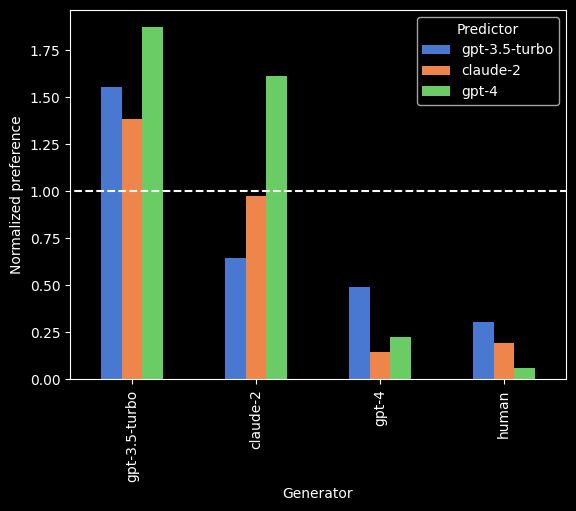

In [122]:
# plot counts of prefered_generator per predictor model normalized by total count
predictor_to_preference = {}

for predictor, df_ in df.groupby("predictor"):
    df_ = df_.copy()
    generator_counts = Counter(df_["generator1"])
    generator_counts.update(df_["generator2"])
    # normalize counts
    total = sum(generator_counts.values())
    generator_counts = {k: v / total for k, v in generator_counts.items()}
    # print(generator_counts)

    # count preferred generator
    preference_counts = df_.preferred_generator.value_counts().to_dict()
    total = sum(preference_counts.values())
    preference_counts = {k: v / total for k, v in preference_counts.items()}
    # print(preference_counts)

    # normalize preference_counts by generator_counts
    preference_counts_normalized = {}
    for k, v in preference_counts.items():
        preference_counts_normalized[k] = v / generator_counts[k]

    # print(preference_counts_normalized)
    predictor_to_preference[predictor] = preference_counts_normalized

predictor_to_preference_df = pd.DataFrame(predictor_to_preference)
predictor_to_preference_df = predictor_to_preference_df.reindex(["gpt-3.5-turbo", "claude-2", "gpt-4", "human"])
predictor_to_preference_df = predictor_to_preference_df[["gpt-3.5-turbo", "claude-2", "gpt-4"]]

print(predictor_to_preference_df)
predictor_to_preference_df.plot.bar()
plt.xlabel("Generator")
plt.ylabel("Normalized preference")
plt.legend(title="Predictor")
plt.hlines(1, -1, 4, linestyles="dashed")


## if models recognize a fable as written by themselves, is that correlated with an increased likelihood of preferring that fable?

claude-2 (396, 17)
(394, 18)
--------------------------------------------------------------------------------
predicted_generator
self     201
other    193
Name: count, dtype: int64
--------------------------------------------------------------------------------
preferred_generator
other    203
self     191
Name: count, dtype: int64
--------------------------------------------------------------------------------
gpt-3.5-turbo (1134, 17)
(1134, 18)
--------------------------------------------------------------------------------
predicted_generator
self     918
other    216
Name: count, dtype: int64
--------------------------------------------------------------------------------
preferred_generator
self     880
other    254
Name: count, dtype: int64
--------------------------------------------------------------------------------
gpt-4 (541, 17)
(535, 18)
--------------------------------------------------------------------------------
predicted_generator
other    422
self     113
Name: co

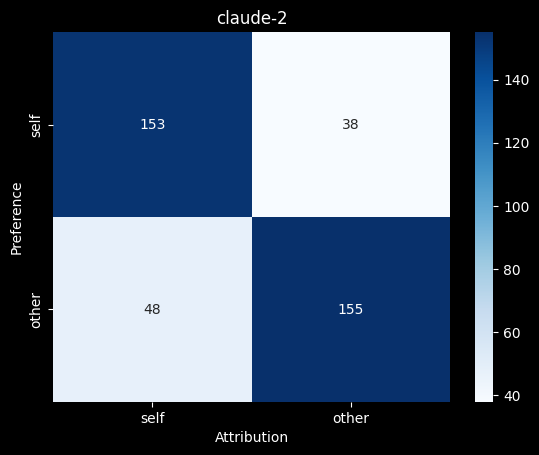

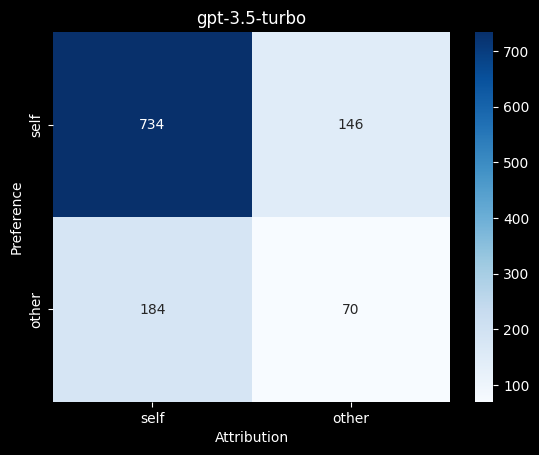

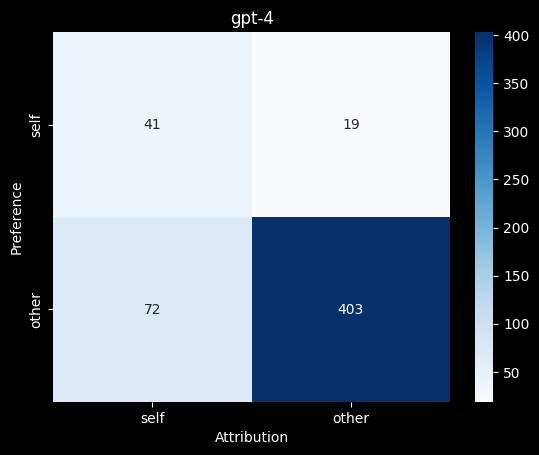

In [158]:

for predictor, df_ in df.groupby("predictor"):
    df_ = df_.copy()
    
    # filter to test cases involving the predictor as generator1 or generator2
    df_ = df_[(df_["generator1"] == predictor) | (df_["generator2"] == predictor)]
    print(predictor, df_.shape)

    # rename and gerator1 and generator2 that is not the predictor to "other"
    df_["generator1"] = df_["generator1"].apply(lambda x: "other" if x != predictor else "self")
    df_["generator2"] = df_["generator2"].apply(lambda x: "other" if x != predictor else "self")
    df_["preferred_generator"] = df_["preferred_generator"].apply(lambda x: "other" if x != predictor else "self")

    # create a column with the predicted generator using the "prediction" column (values: "fable1", "fable2") to look up either generator1 or generator2
    df_["predicted_generator"] = pd.NA
    for idx, row in df_.iterrows():
        if row["prediction"] == "fable1":
            df_.loc[idx, "predicted_generator"] = row["generator1"]
        elif row["prediction"] == "fable2":
            df_.loc[idx, "predicted_generator"] = row["generator2"]

    df_.dropna(inplace=True)
    print(df_.shape)
    # 
    print(80*"-")
    print(df_.predicted_generator.value_counts())
    print(80*"-")
    print(df_.preferred_generator.value_counts())
    print(80*"-")

    # correlate preference and attribution and plot a confusion matrix
    cm = confusion_matrix(df_["preferred_generator"].values, df_["predicted_generator"].values, labels=["self", "other"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["self", "other"], yticklabels=["self", "other"])
    plt.xlabel("Attribution")
    plt.ylabel("Preference")
    plt.title(predictor)


    print(80*"=")



    # plt.figure()
    # y_preference = df_["preferred_generator"].values
    # y_attribution = df_["prediction"].values
    # cm = confusion_matrix(y_preference, y_attribution)
    # print(cm)
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["gpt-3.5-turbo", "claude-2", "gpt-4"], yticklabels=["gpt-3.5-turbo", "claude-2", "gpt-4"])
    # plt.xlabel("Attribution")
    # plt.ylabel("Preference")
    # plt.title(predictor)



# correlation between preference and prediction

## by preferred / attributed position

preference
fable2    516
fable1     96
Name: count, dtype: int64
prediction
fable2     566
fable1      44
unknown      2
Name: count, dtype: int64


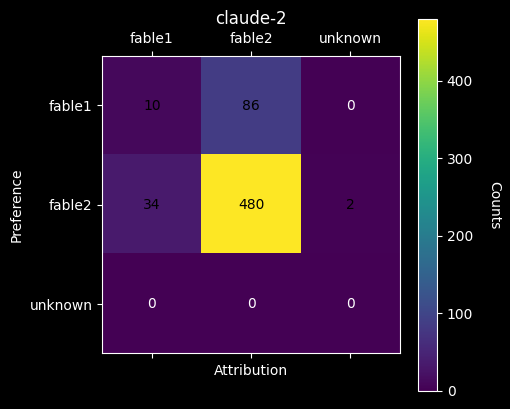

preference
fable2    677
fable1    488
Name: count, dtype: int64
prediction
fable1    801
fable2    364
Name: count, dtype: int64


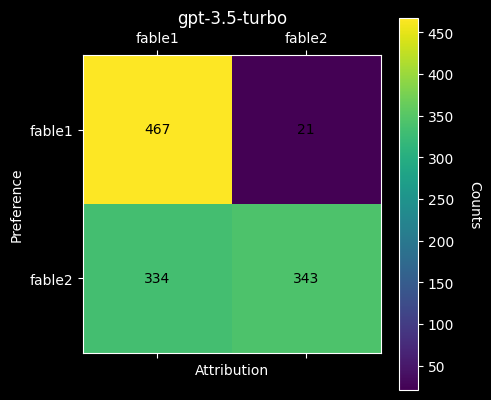

preference
fable2    469
fable1    208
Name: count, dtype: int64
prediction
fable2     401
fable1     270
unknown      4
none         2
Name: count, dtype: int64


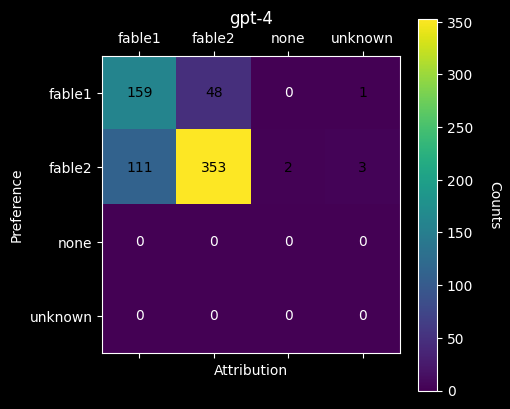

In [88]:
# analyse correlation between preference and prediction (=attribution)
# for each predictor model
# using a confusion matrix
# and plot it including labels
for predictor, df_ in df.groupby("predictor"):
    print(df_.preference.value_counts())
    print(df_.prediction.value_counts())
    cm_counts = confusion_matrix(df_["preference"], df_["prediction"])
    # print(cm_counts)
    # cm = cm_counts.astype("float") / cm_counts.sum(axis=1)[:, np.newaxis]
    # cm = np.round(cm, 2)
    cm = cm_counts
    plt.matshow(cm)
    plt.title(predictor)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Counts", rotation=270, labelpad=20)
    plt.ylabel("Preference")
    plt.xlabel("Attribution")
    # annotate using raw counts; use a white font for dark backgrounds and black font for light backgrounds
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm_counts[i, j], color="white" if cm[i, j] < 0.5 else "black", ha="center", va="center")

    tick_labels = unique_labels(df_.prediction)
    plt.xticks(range(len(tick_labels)), tick_labels)
    plt.yticks(range(len(tick_labels)), tick_labels)
    plt.show()


## by preferred / attributed model

In [120]:
# TODO
